In [1]:
!pip install swin_transformer_pytorch

In [2]:
!pip install timm

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from swin_transformer_pytorch import SwinTransformer
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import timm

In [4]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
# Set CUDA_LAUNCH_BLOCKING environment variable
!export CUDA_LAUNCH_BLOCKING=1

In [6]:
# Set your custom dataset path
data_dir = "gdrive/MyDrive/Colab Notebooks/ucb_capstone_asd_detection/data"

In [7]:
# Set the number of classes in your dataset
num_classes = 2

# Set batch size, number of epochs, and learning rate
batch_size = 30
num_epochs = 20
learning_rate = 1e-5

In [8]:
average  = torch.Tensor([0,0,0])
standard_dev = torch.Tensor([0,0,0])
images = ImageFolder(data_dir+'/train', transforms.ToTensor())
for image in images:
    average += image[0].mean([1,2])
    standard_dev += image[0].std([1,2])
average / len(images) , standard_dev / len(images)

(tensor([0.0013, 0.0014, 0.0011]), tensor([0.0100, 0.0114, 0.0106]))

In [9]:
stats = ((average / len(images)).tolist(), (standard_dev / len(images)).tolist())
data_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize(*stats,inplace=True)
                                    ])

In [10]:
# Load your custom dataset
image_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

In [11]:
# Split the dataset into train and validation sets
train_size = int(0.7 * len(image_dataset))
val_size = len(image_dataset) - train_size
#train_dataset, val_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size])
train_dataset, val_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size])

In [12]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


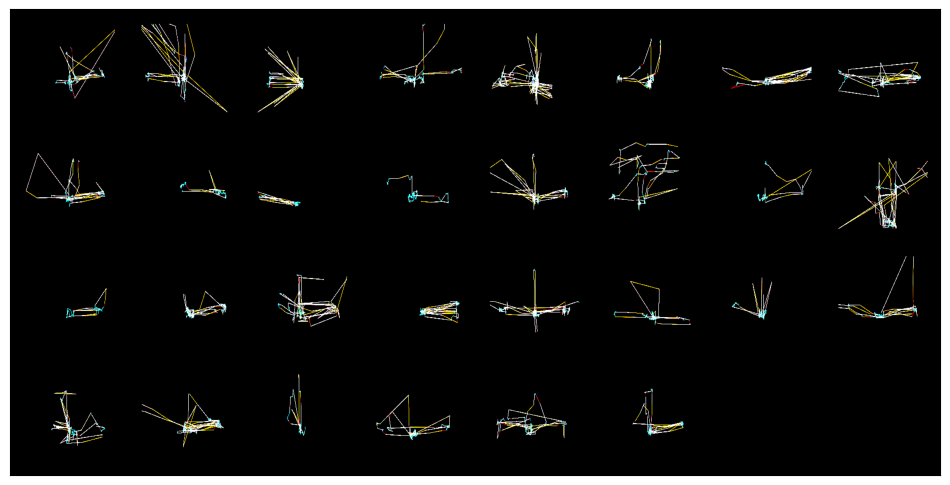

In [14]:
show_batch(train_loader);

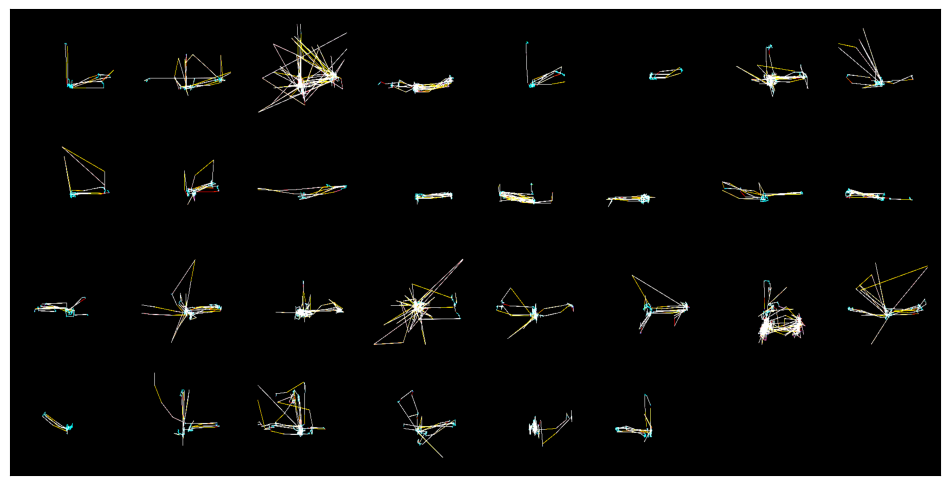

In [15]:
show_batch(val_loader);

In [16]:
# Load a pre-trained Swin Transformer model (Swin-B)
model = timm.create_model("swin_base_patch4_window7_224", pretrained=True)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [17]:
# Modify the final classification head for 2 classes
#model.head = nn.Linear(model.head.in_features, num_classes)

In [18]:
# Modify the final layer for binary classification
#model.head = nn.Sequential(
 #   nn.AdaptiveAvgPool2d((1, 1)),
  #  nn.Flatten(),
   ##nn.Sigmoid()  # Apply sigmoid activation
#)

In [19]:
# Modify the final layer for binary classification
model.head = nn.Sequential(
    nn.Conv2d(in_channels=7, out_channels=64, kernel_size=3, padding=1),  # Adjust the number of output channels as needed
    nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(64, 1),  # Single output node for binary classification
    nn.Sigmoid()  # Apply sigmoid activation
)


In [20]:
# Modify the final layer for binary classification
#model.head = nn.Sequential(
#    nn.AdaptiveAvgPool2d((1, 1)),  # Pool the input to (1, 1)
#    nn.Flatten(),
#    nn.Linear(16*7, 1),  # Output a single value for binary classification
#    nn.Sigmoid()  # Apply sigmoid activation for binary classification
#)

In [21]:
# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

In [22]:
# Define loss function and optimizer
#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Lists to store training and validation losses
train_losses = []
val_losses = []

# Fine-tuning loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        labels = (labels.view(-1, 1)).float()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.5f}, Validation Loss: {val_loss:.5f}, Validation Accuracy: {100 * correct / total:.2f}%")


Epoch 1/20, Train Loss: 0.43136, Validation Loss: 0.39904, Validation Accuracy: 9.09%
Epoch 2/20, Train Loss: 0.34194, Validation Loss: 0.51774, Validation Accuracy: 9.09%
Epoch 3/20, Train Loss: 0.33883, Validation Loss: 0.30577, Validation Accuracy: 9.09%
Epoch 4/20, Train Loss: 0.33490, Validation Loss: 0.22123, Validation Accuracy: 9.09%
Epoch 5/20, Train Loss: 0.33330, Validation Loss: 0.11065, Validation Accuracy: 9.09%
Epoch 6/20, Train Loss: 0.34239, Validation Loss: 0.61294, Validation Accuracy: 9.09%
Epoch 7/20, Train Loss: 0.33317, Validation Loss: 0.21719, Validation Accuracy: 9.09%
Epoch 8/20, Train Loss: 0.33923, Validation Loss: 0.50131, Validation Accuracy: 9.09%
Epoch 9/20, Train Loss: 0.33567, Validation Loss: 0.30683, Validation Accuracy: 9.09%
Epoch 10/20, Train Loss: 0.34115, Validation Loss: 0.60577, Validation Accuracy: 9.09%
Epoch 11/20, Train Loss: 0.33721, Validation Loss: 0.30686, Validation Accuracy: 9.09%
Epoch 12/20, Train Loss: 0.33496, Validation Loss: 0

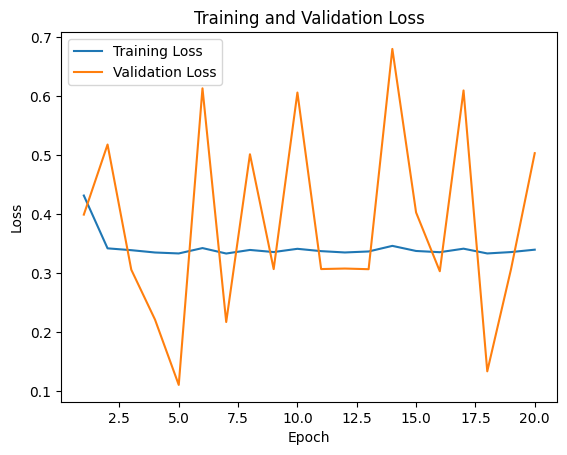

In [24]:
# Plot the training and validation loss
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [25]:
# Save the fine-tuned model
torch.save(model.state_dict(), 'fine_tuned_swin.pth')